[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


AAPL columns: ['Close', 'High', 'Low', 'Open', 'Volume']
SPY columns: ['Close', 'High', 'Low', 'Open', 'Volume']


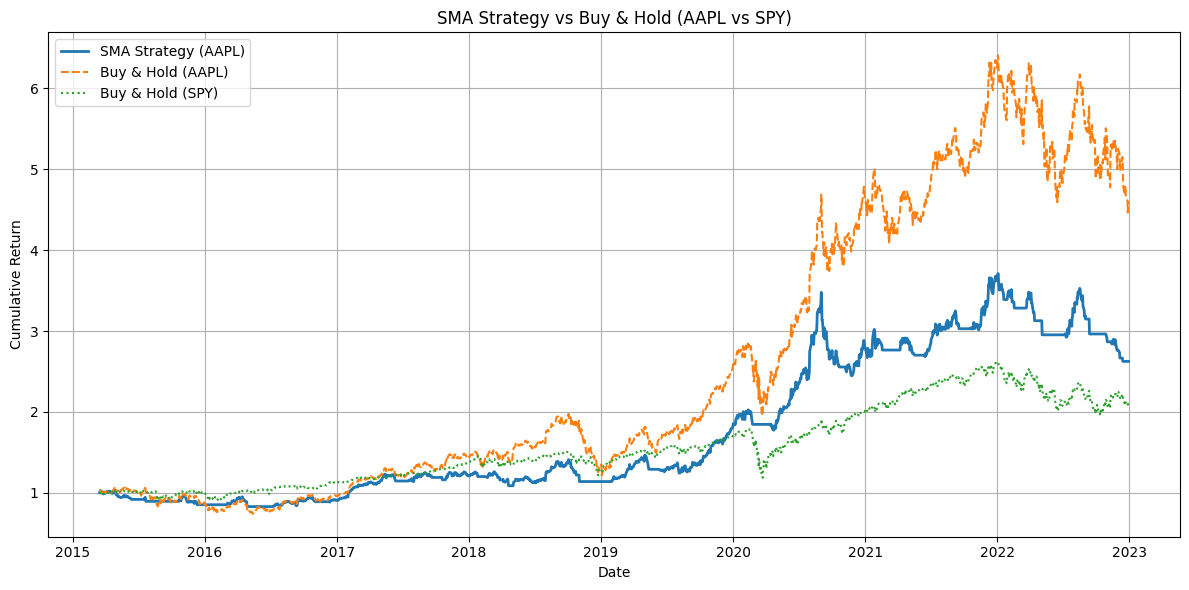

In [13]:
# ==========================================
# 1. Setup Environment
# ==========================================
!pip install yfinance pandas matplotlib -q

# ==========================================
# 2. Imports and Setup
# ==========================================
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

symbol = 'AAPL'
benchmark = 'SPY'
start_date = '2015-01-01'
end_date = '2022-12-31'

# ==========================================
# 3. Download Data
# ==========================================
aapl = yf.download(symbol, start=start_date, end=end_date, auto_adjust=True)
spy = yf.download(benchmark, start=start_date, end=end_date, auto_adjust=True)

# ==========================================
# 4. Handle MultiIndex (if it exists)
# ==========================================
if isinstance(aapl.columns, pd.MultiIndex):
    aapl.columns = aapl.columns.map(lambda col: col[0])  # flatten
if isinstance(spy.columns, pd.MultiIndex):
    spy.columns = spy.columns.map(lambda col: col[0])  # flatten

# Confirm you have the correct columns
print("AAPL columns:", aapl.columns.tolist())
print("SPY columns:", spy.columns.tolist())

# ==========================================
# 5. Compute SMA Strategy
# ==========================================
# Check 'Close' column exists
if 'Close' not in aapl.columns:
    raise KeyError("The 'Close' column is missing in AAPL data.")

aapl['SMA_50'] = aapl['Close'].rolling(window=50).mean()
aapl = aapl.dropna().copy()

# Trading signals
aapl['Signal'] = np.where(aapl['Close'] > aapl['SMA_50'], 1, 0)
aapl['Position'] = aapl['Signal'].shift(1).fillna(0)

# ==========================================
# 6. Backtest AAPL Strategy
# ==========================================
aapl['Daily_Return'] = aapl['Close'].pct_change().fillna(0)
aapl['Strategy_Return'] = aapl['Daily_Return'] * aapl['Position']
aapl['Cumulative_Strategy'] = (1 + aapl['Strategy_Return']).cumprod()
aapl['Cumulative_BuyHold'] = (1 + aapl['Daily_Return']).cumprod()

# ==========================================
# 7. SPY Benchmark
# ==========================================
spy = spy.loc[aapl.index]  # align dates
spy['Daily_Return'] = spy['Close'].pct_change().fillna(0)
spy['Cumulative_SPY'] = (1 + spy['Daily_Return']).cumprod()

# ==========================================
# 8. Plot Results
# ==========================================
plt.figure(figsize=(12,6))
plt.plot(aapl.index, aapl['Cumulative_Strategy'], label='SMA Strategy (AAPL)', linewidth=2)
plt.plot(aapl.index, aapl['Cumulative_BuyHold'], label='Buy & Hold (AAPL)', linestyle='--')
plt.plot(spy.index, spy['Cumulative_SPY'], label='Buy & Hold (SPY)', linestyle=':')
plt.title("SMA Strategy vs Buy & Hold (AAPL vs SPY)")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()
